In [1]:
# BLOCK 5
# Import libraries
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_and_split_data(dataset, min_tokens=256, max_length=256):
    """
    Tokenize, filter, and split the dataset.
    - Tokenize texts
    - Filter out entries with fewer than min_tokens
    - Cap the token length at max_length
    - Split the dataset into train, validation, and test sets
    """
    # Tokenize texts
    dataset['tokens'] = dataset['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=max_length))

    # Filter out rows where the token length is less than min_tokens
    dataset = dataset[dataset['tokens'].apply(len) >= min_tokens]

    # Split the dataset into train, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)  # Splitting 70% for train, 30% for temp_data
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # Splitting temp_data into 50% validation and 50% test

    return train_data, val_data, test_data

# Read the dataset
dataset_train = pd.read_csv('final_train.csv')
dataset_test = pd.read_csv('final_test.csv')

###############
# Limit dataset size for pipeline testing
# Comment this out in real pipeline
dataset_train = dataset_train[:100]
dataset_test = dataset_test[:100]
# dataset_train = dataset_train[:3469]
# dataset_test = dataset_test[:865]
###############

# Combine train and test datasets for preprocessing
combined_dataset = pd.concat([dataset_train, dataset_test])

# Preprocess and split the dataset
train_data, val_data, test_data = preprocess_and_split_data(combined_dataset)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

/home/erkkit/nnw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/erkkit/nnw/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Training set size: 117
Validation set size: 25
Test set size: 26


In [2]:
# BLOCK 6
# Verification and label check
def verify_token_lengths_and_labels(data, label='Train'):
    print(f"--- {label} Data Verification ---")
    print(f"{label} set size: {len(data)}")
    all_256_tokens = all(len(tokens) == 256 for tokens in data['tokens'])
    print(f"All data points are 256 tokens: {all_256_tokens}")
    if all_256_tokens:
        print(f"Sample labels from {label} data:")
        print(data['label'].sample(5).to_list())

# Verify train, validation, and test datasets
verify_token_lengths_and_labels(train_data, 'Train')
verify_token_lengths_and_labels(val_data, 'Validation')
verify_token_lengths_and_labels(test_data, 'Test')

--- Train Data Verification ---
Train set size: 117
All data points are 256 tokens: True
Sample labels from Train data:
[1, 0, 0, 1, 0]
--- Validation Data Verification ---
Validation set size: 25
All data points are 256 tokens: True
Sample labels from Validation data:
[0, 1, 1, 1, 1]
--- Test Data Verification ---
Test set size: 26
All data points are 256 tokens: True
Sample labels from Test data:
[1, 1, 0, 0, 1]


In [3]:
# BLOCK 11
import torch
from transformers import BertTokenizer, BertForMaskedLM
import numpy as np
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

def calculate_metrics(token_ids):
    """Calculate metrics for a single text represented by token IDs."""
    # Convert token IDs to tensor
    input_ids = torch.tensor([token_ids])

    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=-1)
    token_probabilities = probabilities[0, :-1].max(dim=-1).values.numpy()
    token_entropy = entropy(probabilities[0, :-1].numpy(), axis=1)
    token_embeddings = model.bert.embeddings.word_embeddings(input_ids)[0].detach().numpy()

    # Calculate semantic similarity (cosine similarity with the average embedding)
    avg_embedding = np.mean(token_embeddings, axis=0)
    similarity_scores = cosine_similarity(token_embeddings, avg_embedding.reshape(1, -1)).flatten()

    # Token lengths
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    token_lengths = np.array([len(token) for token in tokens])

    # Filter out special tokens ([CLS] and [SEP])
    valid_indices = [i for i, token in enumerate(tokens) if token not in ["[CLS]", "[SEP]"]]
    tokens = [tokens[i] for i in valid_indices]
    token_probabilities = token_probabilities[valid_indices]
    token_entropy = token_entropy[valid_indices]
    similarity_scores = similarity_scores[valid_indices]
    token_lengths = token_lengths[valid_indices]

    # Normalize metrics to 0-255
    token_probabilities_normalized = (token_probabilities / token_probabilities.max() * 255).astype(np.uint8)
    token_entropy_normalized = (token_entropy / token_entropy.max() * 255).astype(np.uint8)
    similarity_scores_normalized = (similarity_scores / similarity_scores.max() * 255).astype(np.uint8)
    token_lengths_normalized = (token_lengths / token_lengths.max() * 255).astype(np.uint8)

    return {
        'tokens': tokens,
        'probabilities': token_probabilities_normalized,
        'entropy': token_entropy_normalized,
        'similarity': similarity_scores_normalized,
        'lengths': token_lengths
    }

# Example usage with preprocessed token_ids
sample_token_ids = train_data['tokens'].iloc[0]
metrics = calculate_metrics(sample_token_ids)

# Print metrics for the first few tokens
for i, token in enumerate(metrics['tokens'][:5]):
    print(f"Token: {token}")
    print(f"Probability: {metrics['probabilities'][i]}")
    print(f"Entropy: {metrics['entropy'][i]}")
    print(f"Similarity: {metrics['similarity'][i]}")
    print(f"Length: {metrics['lengths'][i]}\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Token: from
Probability: 246
Entropy: 16
Similarity: 193
Length: 4

Token: man
Probability: 254
Entropy: 0
Similarity: 174
Length: 3

Token: '
Probability: 254
Entropy: 0
Similarity: 175
Length: 1

Token: s
Probability: 254
Entropy: 0
Similarity: 188
Length: 1

Token: very
Probability: 216
Entropy: 37
Similarity: 181
Length: 4



In [5]:
print(train_data['tokens'].iloc[0])

[101, 2013, 2158, 1005, 1055, 2200, 2034, 4440, 2041, 1997, 3011, 1005, 1055, 7224, 2000, 1996, 14430, 4231, 4899, 1010, 2111, 2013, 2035, 2408, 1996, 2088, 2031, 2467, 4999, 2054, 3658, 1999, 1996, 4242, 5943, 2291, 2008, 20626, 2068, 1012, 2750, 1996, 5473, 1998, 1996, 15428, 2008, 17808, 2122, 2220, 6529, 1010, 2027, 2145, 29453, 2094, 2000, 8849, 2686, 1998, 1996, 11358, 2306, 2009, 1012, 1999, 3015, 1000, 1996, 4119, 1997, 11131, 11691, 1010, 1000, 1996, 3166, 2003, 2583, 2000, 2200, 13359, 2135, 4863, 1996, 6666, 1997, 11131, 11691, 1010, 2750, 1996, 4795, 7860, 2023, 23855, 2089, 2556, 1012, 1996, 3720, 4627, 2125, 2011, 7851, 11691, 1998, 4346, 4281, 2005, 1996, 8068, 1010, 4352, 1996, 3213, 2000, 2191, 1037, 6428, 1998, 2062, 3305, 3085, 4366, 2101, 2006, 1999, 1996, 2147, 1012, 11691, 1010, 2004, 2649, 1999, 1996, 3720, 1010, 2003, 2411, 1996, 7541, 4774, 2000, 3011, 1010, 5834, 2006, 1996, 2051, 1010, 1998, 2003, 15192, 2170, 1000, 3011, 1005, 1055, 1005, 5519, 1005, 1000, 2

In [6]:
# BLOCK 12: Process and Save Data with Labels
import numpy as np
from PIL import Image, ImageDraw
from multiprocessing import Pool
from tqdm import tqdm

def pad_or_truncate_metrics(metrics, target_length=256):
    """Pad or truncate the metrics to ensure the token array has the target length."""
    current_length = len(metrics['tokens'])
    if current_length < target_length:
        for key in metrics.keys():
            padding = [0] * (target_length - current_length)
            metrics[key] = np.concatenate((metrics[key], padding))
    elif current_length > target_length:
        for key in metrics.keys():
            metrics[key] = metrics[key][:target_length]
    return metrics

def spread_normalization(data, scale=255):
    """Normalize data using a square root transformation to reduce high-end compression."""
    sqrt_data = np.sqrt(data)
    normalized_data = (sqrt_data - np.min(sqrt_data)) / (np.max(sqrt_data) - np.min(sqrt_data))
    return (normalized_data * scale).astype(int)

def clip_and_normalize_metrics(metrics):
    """Adjusts the metrics by clipping to a range between the lowest non-zero and highest non-255 values for 'probabilities' and 'similarity'."""
    keys_to_normalize = ['probabilities', 'similarity']
    for key in keys_to_normalize:
        if key in metrics:
            data = metrics[key]
            min_val = np.min(data[data > 0])
            max_val = np.max(data[data < 255])
            clipped_data = np.where(data == 0, min_val, data)
            clipped_data = np.where(clipped_data == 255, max_val, clipped_data)
            metrics[key] = ((clipped_data - min_val) / (max_val - min_val) * 255).astype(int)

    metrics['probabilities'] = np.where((255 - metrics['probabilities']) * 10 < 255,
        metrics['probabilities'] - ((255 - metrics['probabilities']) * 10),
        metrics['probabilities'])
    return metrics

def generate_circle_image(metrics, img_width=256, img_height=256):
    """Generate a 256x256 pixel grayscale image with circles based on metrics."""
    img = Image.new('L', (img_width, img_height), color='white')  # 'L' mode for grayscale
    draw = ImageDraw.Draw(img)

    centers = []  # To store center points for the polyline

    for idx in range(len(metrics['tokens'])):
        # Normalize coordinates to fit within the image dimensions
        x_center = int(metrics['probabilities'][idx])
        y_center = int(metrics['similarity'][idx])
        centers.append((x_center, y_center))

        # radius = 2
        radius = int(metrics['lengths'][idx])
        entropy = int(metrics['entropy'][idx])  # Grayscale intensity from 0 to 255

        # Calculate top left and bottom right coordinates of the circle
        top_left = (x_center - radius, y_center - radius)
        bottom_right = (x_center + radius, y_center + radius)

        # Draw the circle
        draw.ellipse([top_left, bottom_right], outline=entropy)

    # Draw the polyline connecting all centers
    draw.line(centers, fill='black', width=1)

    return img

def process_single_entry(entry):
    token_ids, label = entry
    metrics = calculate_metrics(token_ids)
    metrics = pad_or_truncate_metrics(metrics)
    all_metrics = metrics  # Store original metrics before further manipulation

    # Apply normalization and adjustments for image generation
    metrics = clip_and_normalize_metrics(metrics)
    img = generate_circle_image(metrics)
    return np.array(img), all_metrics, label

def process_images_and_metrics(tokens, labels):
    images = []
    all_metrics = []
    all_labels = []
    with Pool(processes=1) as pool:  # Adjust number of processes based on available CPU cores
        results = list(tqdm(pool.imap(process_single_entry, zip(tokens, labels)), total=len(tokens)))
    for img, metrics, label in results:
        images.append(img)
        all_metrics.append(metrics)
        all_labels.append(label)
    return images, all_metrics, all_labels

# Assuming data has already been loaded into train_data, val_data, test_data
train_images, train_metrics, train_labels = process_images_and_metrics(train_data['tokens'], train_data['label'])
val_images, val_metrics, val_labels = process_images_and_metrics(val_data['tokens'], val_data['label'])
test_images, test_metrics, test_labels = process_images_and_metrics(test_data['tokens'], test_data['label'])

# Save to .npz files
np.savez_compressed('npz_results/train_data.npz', images=train_images, metrics=train_metrics, labels=train_labels)
np.savez_compressed('npz_results/val_data.npz', images=val_images, metrics=val_metrics, labels=val_labels)
np.savez_compressed('npz_results/test_data.npz', images=test_images, metrics=test_metrics, labels=test_labels)


  0%|          | 0/117 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [7]:
# BLOCK 12: Process and Save Data with Labels WSL2/venv
import numpy as np
from PIL import Image, ImageDraw
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def pad_or_truncate_metrics(metrics, target_length=256):
    """Pad or truncate the metrics to ensure the token array has the target length."""
    current_length = len(metrics['tokens'])
    if current_length < target_length:
        for key in metrics.keys():
            padding = [0] * (target_length - current_length)
            metrics[key] = np.concatenate((metrics[key], padding))
    elif current_length > target_length:
        for key in metrics.keys():
            metrics[key] = metrics[key][:target_length]
    return metrics

def spread_normalization(data, scale=255):
    """Normalize data using a square root transformation to reduce high-end compression."""
    sqrt_data = np.sqrt(data)
    normalized_data = (sqrt_data - np.min(sqrt_data)) / (np.max(sqrt_data) - np.min(sqrt_data))
    return (normalized_data * scale).astype(int)

def clip_and_normalize_metrics(metrics):
    """Adjusts the metrics by clipping to a range between the lowest non-zero and highest non-255 values for 'probabilities' and 'similarity'."""
    keys_to_normalize = ['probabilities', 'similarity']
    for key in keys_to_normalize:
        if key in metrics:
            data = metrics[key]
            min_val = np.min(data[data > 0])
            max_val = np.max(data[data < 255])
            clipped_data = np.where(data == 0, min_val, data)
            clipped_data = np.where(clipped_data == 255, max_val, clipped_data)
            metrics[key] = ((clipped_data - min_val) / (max_val - min_val) * 255).astype(int)

    metrics['probabilities'] = np.where((255 - metrics['probabilities']) * 10 < 255,
        metrics['probabilities'] - ((255 - metrics['probabilities']) * 10),
        metrics['probabilities'])
    return metrics

def generate_circle_image(metrics, img_width=256, img_height=256):
    """Generate a 256x256 pixel grayscale image with circles based on metrics."""
    img = Image.new('L', (img_width, img_height), color='white')  # 'L' mode for grayscale
    draw = ImageDraw.Draw(img)

    centers = []  # To store center points for the polyline

    for idx in range(len(metrics['tokens'])):
        # Normalize coordinates to fit within the image dimensions
        x_center = int(metrics['probabilities'][idx])
        y_center = int(metrics['similarity'][idx])
        centers.append((x_center, y_center))

        # radius = 2
        radius = int(metrics['lengths'][idx])
        entropy = int(metrics['entropy'][idx])  # Grayscale intensity from 0 to 255

        # Calculate top left and bottom right coordinates of the circle
        top_left = (x_center - radius, y_center - radius)
        bottom_right = (x_center + radius, y_center + radius)

        # Draw the circle
        draw.ellipse([top_left, bottom_right], outline=entropy)

    # Draw the polyline connecting all centers
    draw.line(centers, fill='black', width=1)

    return img

def process_single_entry(entry):
    token_ids, label = entry
    metrics = calculate_metrics(token_ids)
    metrics = pad_or_truncate_metrics(metrics)
    all_metrics = metrics  # Store original metrics before further manipulation

    # Apply normalization and adjustments for image generation
    metrics = clip_and_normalize_metrics(metrics)
    img = generate_circle_image(metrics)
    return np.array(img), all_metrics, label

def process_images_and_metrics(tokens, labels):
    images = []
    all_metrics = []
    all_labels = []
    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_single_entry, entry) for entry in zip(tokens, labels)]
        for future in tqdm(as_completed(futures), total=len(tokens)):
            try:
                img, metrics, label = future.result()
                images.append(img)
                all_metrics.append(metrics)
                all_labels.append(label)
            except Exception as e:
                print(f"Error processing entry: {e}")
    return images, all_metrics, all_labels

if __name__ == "__main__":
    # Assuming data has already been loaded into train_data, val_data, test_data
    train_images, train_metrics, train_labels = process_images_and_metrics(train_data['tokens'], train_data['label'])
    val_images, val_metrics, val_labels = process_images_and_metrics(val_data['tokens'], val_data['label'])
    test_images, test_metrics, test_labels = process_images_and_metrics(test_data['tokens'], test_data['label'])

    # Save to .npz files
    np.savez_compressed('npz_results/train_data.npz', images=train_images, metrics=train_metrics, labels=train_labels)
    np.savez_compressed('npz_results/val_data.npz', images=val_images, metrics=val_metrics, labels=val_labels)
    np.savez_compressed('npz_results/test_data.npz', images=test_images, metrics=test_metrics, labels=test_labels)


  0%|          | 0/117 [00:34<?, ?it/s]


In [4]:
# BLOCK 12a: Process and Save Data with Labels in local Windows machine
import numpy as np
from PIL import Image, ImageDraw
from multiprocessing import Pool
from tqdm import tqdm

def pad_or_truncate_metrics(metrics, target_length=256):
    """Pad or truncate the metrics to ensure the token array has the target length."""
    current_length = len(metrics['tokens'])
    if current_length < target_length:
        for key in metrics.keys():
            padding = [0] * (target_length - current_length)
            metrics[key] = np.concatenate((metrics[key], padding))
    elif current_length > target_length:
        for key in metrics.keys():
            metrics[key] = metrics[key][:target_length]
    return metrics

def spread_normalization(data, scale=255):
    """Normalize data using a square root transformation to reduce high-end compression."""
    sqrt_data = np.sqrt(data)
    normalized_data = (sqrt_data - np.min(sqrt_data)) / (np.max(sqrt_data) - np.min(sqrt_data))
    return (normalized_data * scale).astype(int)

def clip_and_normalize_metrics(metrics):
    """Adjusts the metrics by clipping to a range between the lowest non-zero and highest non-255 values for 'probabilities' and 'similarity'."""
    keys_to_normalize = ['probabilities', 'similarity']
    for key in keys_to_normalize:
        if key in metrics:
            data = metrics[key]
            min_val = np.min(data[data > 0])
            max_val = np.max(data[data < 255])
            clipped_data = np.where(data == 0, min_val, data)
            clipped_data = np.where(clipped_data == 255, max_val, clipped_data)
            metrics[key] = ((clipped_data - min_val) / (max_val - min_val) * 255).astype(int)

    metrics['probabilities'] = np.where((255 - metrics['probabilities']) * 10 < 255,
        metrics['probabilities'] - ((255 - metrics['probabilities']) * 10),
        metrics['probabilities'])
    return metrics

def generate_circle_image(metrics, img_width=256, img_height=256):
    """Generate a 256x256 pixel grayscale image with circles based on metrics."""
    img = Image.new('L', (img_width, img_height), color='white')  # 'L' mode for grayscale
    draw = ImageDraw.Draw(img)

    centers = []  # To store center points for the polyline

    for idx in range(len(metrics['tokens'])):
        # Normalize coordinates to fit within the image dimensions
        x_center = int(metrics['probabilities'][idx])
        y_center = int(metrics['similarity'][idx])
        centers.append((x_center, y_center))

        # radius = 2
        radius = int(metrics['lengths'][idx])
        entropy = int(metrics['entropy'][idx])  # Grayscale intensity from 0 to 255

        # Calculate top left and bottom right coordinates of the circle
        top_left = (x_center - radius, y_center - radius)
        bottom_right = (x_center + radius, y_center + radius)

        # Draw the circle
        draw.ellipse([top_left, bottom_right], outline=entropy)

    # Draw the polyline connecting all centers
    draw.line(centers, fill='black', width=1)

    return img

def process_single_entry(entry):
    token_ids, label = entry
    metrics = calculate_metrics(token_ids)
    metrics = pad_or_truncate_metrics(metrics)
    all_metrics = metrics  # Store original metrics before further manipulation

    # Apply normalization and adjustments for image generation
    metrics = clip_and_normalize_metrics(metrics)
    img = generate_circle_image(metrics)
    return np.array(img), all_metrics, label

def process_images_and_metrics(tokens, labels):
    images = []
    all_metrics = []
    all_labels = []
    with Pool(processes=4) as pool:  # Reduced the number of processes for better stability
        results = list(tqdm(pool.imap(process_single_entry, zip(tokens, labels)), total=len(tokens)))
    for img, metrics, label in results:
        images.append(img)
        all_metrics.append(metrics)
        all_labels.append(label)
    return images, all_metrics, all_labels

# Assuming data has already been loaded into train_data, val_data, test_data
train_images, train_metrics, train_labels = process_images_and_metrics(train_data['tokens'], train_data['label'])
val_images, val_metrics, val_labels = process_images_and_metrics(val_data['tokens'], val_data['label'])
test_images, test_metrics, test_labels = process_images_and_metrics(test_data['tokens'], test_data['label'])

# Save to .npz files
np.savez_compressed('train_data.npz', images=train_images, metrics=train_metrics, labels=train_labels)
np.savez_compressed('val_data.npz', images=val_images, metrics=val_metrics, labels=val_labels)
np.savez_compressed('test_data.npz', images=test_images, metrics=test_metrics, labels=test_labels)

100%|██████████| 26/26 [00:11<00:00,  2.22it/s]


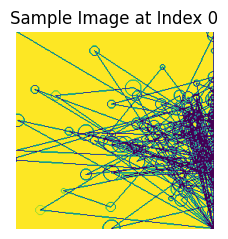

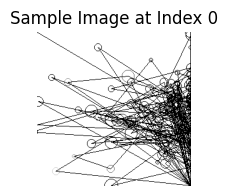

Metrics for Entry 0:
probabilities: [156 255 255 255 212]
entropy: [16  0  0  0 37]
similarity: [156 119 121 146 133]
lengths: [4 3 1 1 4]


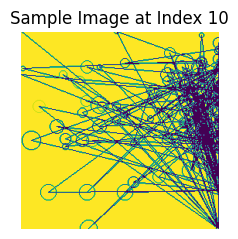

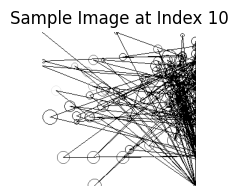

Metrics for Entry 10:
probabilities: [173 255 255 255 255]
entropy: [124   0   0   0   0]
similarity: [108  72  51 108 255]
lengths: [1 5 1 1 3]


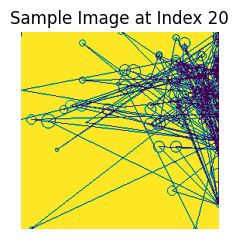

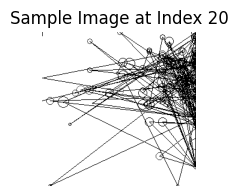

Metrics for Entry 20:
probabilities: [255 255 255 255 255]
entropy: [0 1 0 0 1]
similarity: [ 59   8  39 224  83]
lengths: [2 6 4 3 9]


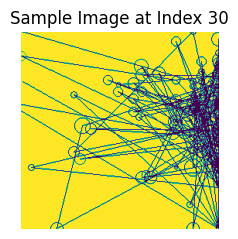

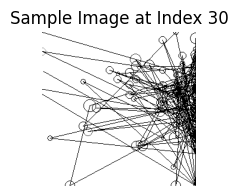

Metrics for Entry 30:
probabilities: [  2 200 255 255 218]
entropy: [255   5   0   0  31]
similarity: [ 65 176  93 128 224]
lengths: [7 2 1 1 4]


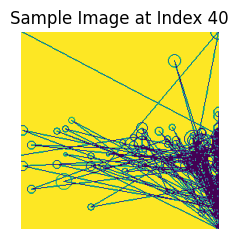

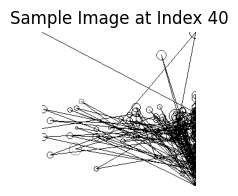

Metrics for Entry 40:
probabilities: [  0 145 255 222 255]
entropy: [255   6   0   3   0]
similarity: [160 137 159 207 243]
lengths: [6 4 3 2 1]


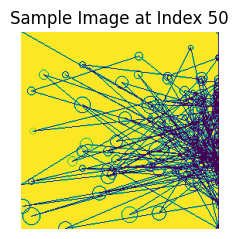

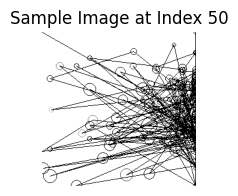

Metrics for Entry 50:
probabilities: [ 88 255 255 255 255]
entropy: [209   0   0   1   0]
similarity: [ 47 198  82 110 170]
lengths: [4 2 3 7 9]


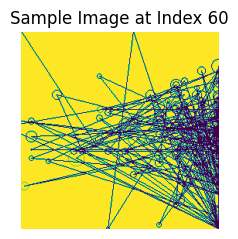

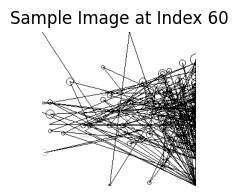

Metrics for Entry 60:
probabilities: [255 255 255 255 255]
entropy: [2 0 0 1 0]
similarity: [112 133 142 185 190]
lengths: [3 5 1 4 3]


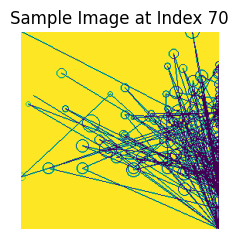

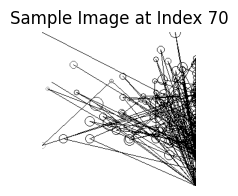

Metrics for Entry 70:
probabilities: [ 16 255 255 222 145]
entropy: [255   0   0   1   5]
similarity: [ 83 229 144 102 177]
lengths: [4 2 7 7 7]


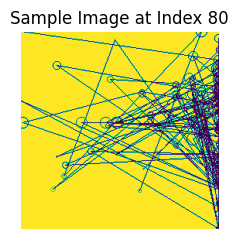

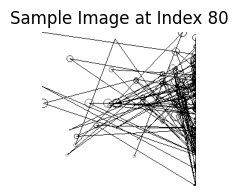

Metrics for Entry 80:
probabilities: [158 255 255 222 255]
entropy: [201   1   0  38   0]
similarity: [178  76 120  32  60]
lengths: [1 5 2 6 5]


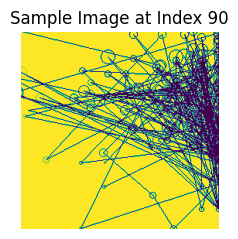

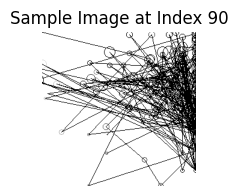

Metrics for Entry 90:
probabilities: [108 255 255 200 255]
entropy: [156   0   0   5   0]
similarity: [170  15 130  64 230]
lengths: [1 6 2 4 3]


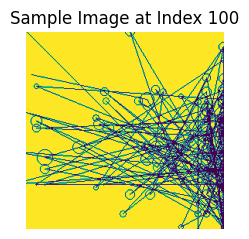

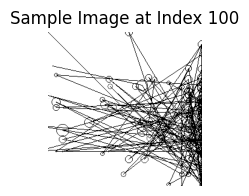

Metrics for Entry 100:
probabilities: [  7 156 255 255 233]
entropy: [255  14   0   0   2]
similarity: [ 56  88 255 183 211]
lengths: [4 9 1 4 6]


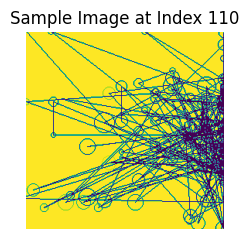

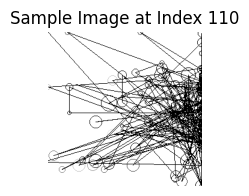

Metrics for Entry 110:
probabilities: [255 233 255 255 255]
entropy: [2 6 0 0 0]
similarity: [185 120 163 181  87]
lengths: [1 7 5 2 3]


In [ ]:
# Sanity check for image and mterics generation
import matplotlib.pyplot as plt

def plot_image(image, title):
    """Helper function to plot an image with a title."""
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def print_metrics(metrics, idx):
    """Helper function to print selected metrics."""
    print(f"Metrics for Entry {idx}:")
    keys_to_display = ['probabilities', 'entropy', 'similarity', 'lengths']  # Example keys
    for key in keys_to_display:
        if key in metrics:
            print(f"{key}: {metrics[key][:5]}")  # Print first 5 values as an example

# def sanity_check_images_and_metrics(images, metrics, step=20):
#     """Performs a sanity check by displaying images and printing metrics at specified intervals."""
#     for idx in range(0, len(images), step):
#         plot_image(images[idx], f"Sample Image at Index {idx}")
#         print_metrics(metrics[idx], idx)

def sanity_check_images_and_metrics(images, metrics, step=400):
    """Performs a sanity check by displaying images and printing metrics at specified intervals."""
    for idx in range(0, len(images), step):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(2.56, 2.56))  # 256x256 pixels
        plt.imshow(images[idx])
        plt.title(f"Sample Image at Index {idx}")
        plt.axis('off')
        plt.show()
        plot_image(images[idx], f"Sample Image at Index {idx}")
        print_metrics(metrics[idx], idx)

# Assuming you have already processed the images and metrics
# Uncomment and run these lines when you have your data ready

# Sanity check for training data
sanity_check_images_and_metrics(train_images, train_metrics)

# If needed, also perform sanity checks for validation and test datasets
# sanity_check_images_and_metrics(val_images, val_metrics)
# sanity_check_images_and_metrics(test_images, test_metrics)


Entry 1:
Image Array Shape: (256, 256)
Metrics: {'tokens': array(['from', 'man', "'", 's', 'very', 'first', 'trip', 'out', 'of',
       'earth', "'", 's', 'atmosphere', 'to', 'the', 'iconic', 'moon',
       'landing', ',', 'people', 'from', 'all', 'across', 'the', 'world',
       'have', 'always', 'wondered', 'what', 'lies', 'in', 'the',
       'unknown', 'solar', 'system', 'that', 'surrounds', 'them', '.',
       'despite', 'the', 'danger', 'and', 'the', 'failures', 'that',
       'plagued', 'these', 'early', 'scientists', ',', 'they', 'still',
       'strive', '##d', 'to', 'explore', 'space', 'and', 'the', 'planets',
       'within', 'it', '.', 'in', 'writing', '"', 'the', 'challenge',
       'of', 'exploring', 'venus', ',', '"', 'the', 'author', 'is',
       'able', 'to', 'very', 'convincing', '##ly', 'explain', 'the',
       'benefits', 'of', 'exploring', 'venus', ',', 'despite', 'the',
       'dangerous', 'challenges', 'this', 'endeavor', 'may', 'present',
       '.', 'the', 'arti

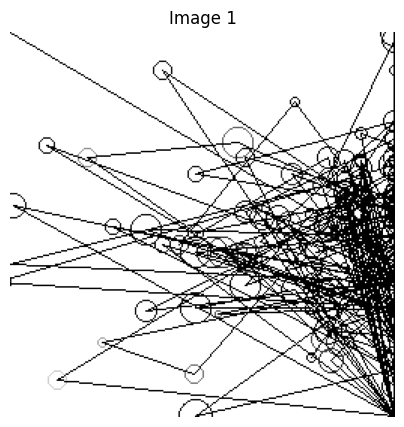


Entry 2:
Image Array Shape: (256, 256)
Metrics: {'tokens': array(['when', 'elect', '##ing', 'the', 'president', 'of', 'the',
       'united', 'states', ',', 'you', 'must', 'vote', 'in', 'favor',
       'of', 'the', 'president', 'you', 'want', '.', 'however', ',',
       'instead', 'of', 'coming', 'down', 'to', 'popular', 'vote', ',',
       'the', 'system', 'uses', 'the', 'electro', '##lux', 'college',
       'to', 'decide', '.', 'the', 'electoral', 'vote', 'works', 'in',
       'that', 'the', 'people', 'of', 'a', 'certain', 'states', 'votes',
       'for', 'their', 'candidate', 'and', 'the', 'majority', 'of',
       'people', 'who', 'vote', 'for', 'a', 'certain', 'president',
       'give', 'their', 'votes', 'to', 'a', 'slate', 'of', 'voters', '.',
       'what', 'this', 'means', 'is', 'that', 'the', 'popular', 'vote',
       'within', 'a', 'state', 'wins', 'the', 'electoral', 'votes', 'of',
       'the', 'electors', 'who', 'then', 'vote', 'for', 'the',
       'president', '.', 'many

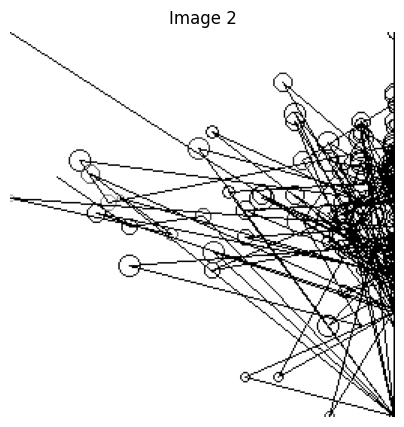


Entry 3:
Image Array Shape: (256, 256)
Metrics: {'tokens': array(['science', 'experiment', 'report', 'introduction', ':', 'as', 'an',
       '8th', '-', 'grade', 'student', ',', 'i', 'recently', 'completed',
       'a', 'science', 'experiment', 'with', 'my', 'group', '.', 'our',
       'goal', 'was', 'to', 'investigate', 'the', 'effects', 'of',
       'different', 'types', 'of', 'fe', '##rti', '##lizer', '##s', 'on',
       'plant', 'growth', '.', 'we', 'chose', 'this', 'experiment',
       'because', 'we', 'were', 'interested', 'in', 'understanding',
       'how', 'plants', 'grow', 'and', 'how', 'different', 'nutrients',
       'can', 'affect', 'their', 'growth', '.', 'experiment', 'design',
       ':', 'we', 'decided', 'to', 'conduct', 'a', 'controlled',
       'experiment', 'with', 'three', 'different', 'types', 'of', 'fe',
       '##rti', '##lizer', '##s', ':', 'organic', ',', 'chemical', ',',
       'and', 'a', 'control', 'group', 'with', 'no', 'fe', '##rti',
       '##lizer', '.

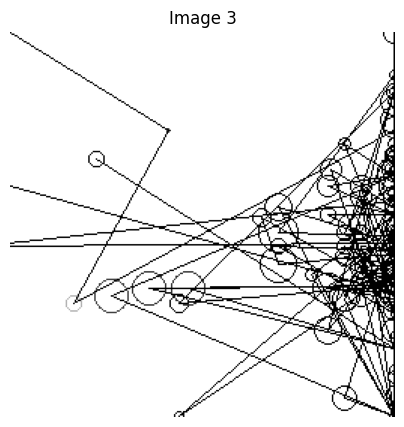


Entry 4:
Image Array Shape: (256, 256)
Metrics: {'tokens': array(['growing', 'up', ',', 'i', 'was', 'convinced', 'that', 'if', 'i',
       'changed', 'my', 'hair', ',', 'my', 'clothes', 'or', 'my',
       'accent', ',', 'then', 'i', 'would', 'be', 'cool', '.', 'i',
       'thought', 'it', 'would', 'make', 'me', 'popular', 'and', 'like',
       '##able', '.', 'i', 'remember', 'going', 'to', 'a', 'new',
       'school', 'and', 'desperately', 'trying', 'to', 'fit', 'in', '.',
       'furthermore', ',', 'i', 'tried', 'to', 'mimic', 'the', 'girls',
       'that', 'were', 'popular', 'in', 'my', 'class', ',', 'thinking',
       'that', 'if', 'i', 'act', 'like', 'them', ',', 'i', 'would', 'be',
       'accepted', '.', 'after', 'months', 'of', 'trying', 'to', 'change',
       'myself', ',', 'i', 'realized', 'that', 'it', 'only', 'made', 'me',
       'feel', 'worse', 'about', 'myself', '.', 'i', 'had', 'stopped',
       'being', 'true', 'to', 'myself', ',', 'and', 'it', 'had', 'made',
       'm

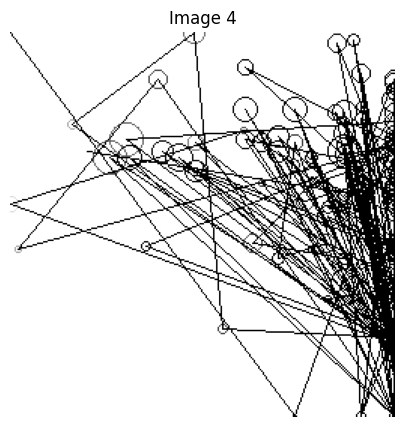


Entry 5:
Image Array Shape: (256, 256)
Metrics: {'tokens': array(['i', 'think', 'it', 'is', 'very', 'valuable', 'because', 'it',
       'knows', 'if', 'you', "'", 're', 'happy', 'or', 'sad', 'which',
       'helps', 'in', 'a', 'lot', 'of', 'ways', '.', 'another',
       'interesting', 'example', 'would', 'be', '"', 'a', 'classroom',
       'computer', 'could', 'recognize', 'when', 'a', 'student', 'is',
       'becoming', 'confused', 'or', 'bored', '.', '"', 'and', 'the',
       'technology', 'is', 'so', 'good', 'it', 'can', 'make', 'computer',
       'animated', 'faces', 'more', 'expressive', 'according', 'to',
       'the', 'text', 'and', 'can', 'too', 'for', 'surgery', 'videos',
       '.', 'and', 'the', 'computer', 'may', 'not', 'detect', 'your',
       'emotional', 'communication', 'but', 'noted', 'dr', '.', 'huang',
       'said', '"', 'so', 'computers', 'need', 'to', 'understand', 'that',
       'too', '.', '"', 'the', 'process', 'begins', 'when', 'the',
       'computer', 'cons

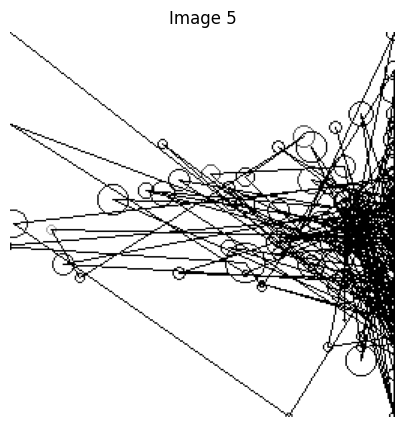

In [5]:
# Block 14
# Verification of .npz structure

import numpy as np
import matplotlib.pyplot as plt

# Load the .npz file
data = np.load('npz_results/train_data.npz', allow_pickle=True)
images = data['images']  # Accessing the images stored in the .npz file
metrics = data['metrics']  # Accessing the metrics stored in the .npz file

# Print and display the first 5 entries
for i in range(5):
    print(f"Entry {i+1}:")
    print("Image Array Shape:", images[i].shape)  # Print the shape of each image array
    print("Metrics:", metrics[i])  # Print the metrics associated with each image

    # Display the image using matplotlib
    plt.figure(figsize=(5, 5))  # Set the figure size for better visibility
    plt.imshow(images[i], cmap='gray')  # Display the image in grayscale
    plt.title(f"Image {i+1}")  # Title with the image number
    plt.axis('off')  # Hide the axes
    plt.show()  # Show the image plot

    print()  # Add an empty line for better readability between entries



Combined Training set size: 117
Combined Validation set size: 25
Combined Test set size: 26
Sanity Check for Train Set - Entry 0:
Image Array Shape: (256, 256)
Metrics:
probabilities: [  2 200 255 255 218]
entropy: [255   5   0   0  31]
similarity: [ 65 176  93 128 224]
lengths: [7 2 1 1 4]


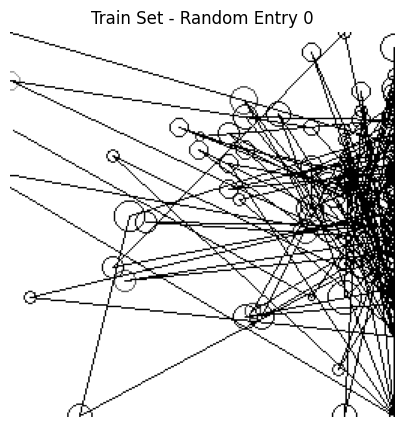

Sanity Check for Validation Set - Entry 8:
Image Array Shape: (256, 256)
Metrics:
probabilities: [  0 255 255 255 255]
entropy: [255   0   0   0   0]
similarity: [255 150 181 155 232]
lengths: [3 4 2 4 2]


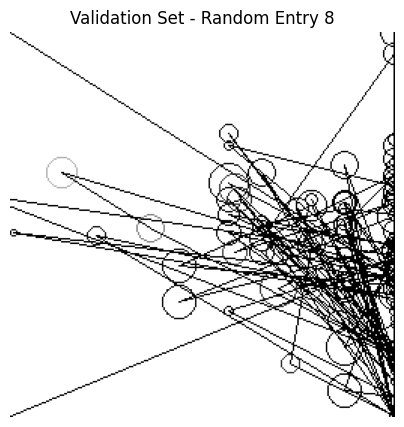

Sanity Check for Test Set - Entry 10:
Image Array Shape: (256, 256)
Metrics:
probabilities: [255 255 255 255 255]
entropy: [2 0 0 0 0]
similarity: [235  85 136 114 157]
lengths: [3 4 2 4 2]


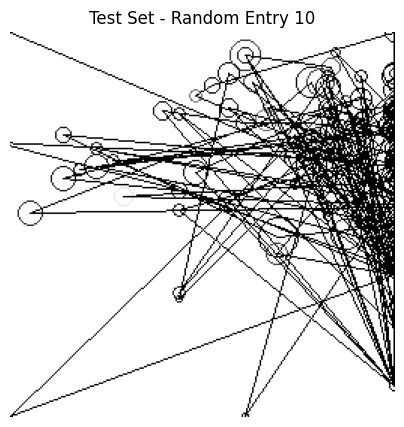

In [6]:
# BLOCK 14a Sanity Check for Combined Data

import os
import numpy as np
import matplotlib.pyplot as plt
import random

def load_combined_data(directory):
    """Load and combine all .npz files from the specified directory."""
    combined_images = []
    combined_metrics = []
    combined_labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.npz'):
            data = np.load(os.path.join(directory, filename), allow_pickle=True)
            combined_images.extend(data['images'])
            combined_metrics.extend(data['metrics'])
            combined_labels.extend(data['labels'])

    return np.array(combined_images), np.array(combined_metrics), np.array(combined_labels)

def sanity_check_random_entry(images, metrics, set_name):
    """Perform a sanity check on a random entry from the given dataset."""
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    metric = metrics[idx]

    # Print metrics for the random entry
    print(f"Sanity Check for {set_name} Set - Entry {idx}:")
    print(f"Image Array Shape: {img.shape}")
    print("Metrics:")
    keys_to_display = ['probabilities', 'entropy', 'similarity', 'lengths']
    for key in keys_to_display:
        if key in metric:
            print(f"{key}: {metric[key][:5]}")  # Print first 5 values as an example

    # Display the image
    plt.figure(figsize=(5, 5))  # Set the figure size for better visibility
    plt.imshow(img, cmap='gray')  # Display the image in grayscale
    plt.title(f"{set_name} Set - Random Entry {idx}")  # Title with the set name and entry number
    plt.axis('off')  # Hide the axes
    plt.show()  # Show the image plot

def main():
    # Load combined data
    train_images, train_metrics, train_labels = load_combined_data('npz_results/train')
    val_images, val_metrics, val_labels = load_combined_data('npz_results/val')
    test_images, test_metrics, test_labels = load_combined_data('npz_results/test')

    print(f"Combined Training set size: {len(train_images)}")
    print(f"Combined Validation set size: {len(val_images)}")
    print(f"Combined Test set size: {len(test_images)}")

    # Perform sanity check on a random entry from each set
    sanity_check_random_entry(train_images, train_metrics, 'Train')
    sanity_check_random_entry(val_images, val_metrics, 'Validation')
    sanity_check_random_entry(test_images, test_metrics, 'Test')

# Run the main function
main()


In [2]:
# BLOCK 15: Train and Validate the CNN on Pure Metrics Data

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score

# Load training and validation data
train_data = np.load('npz_results/train_data.npz', allow_pickle=True)
val_data = np.load('npz_results/val_data.npz', allow_pickle=True)

# Extract metrics and labels
X_train = np.array([metrics['probabilities'] for metrics in train_data['metrics']])
y_train = np.array(train_data['labels'])
X_val = np.array([metrics['probabilities'] for metrics in val_data['metrics']])
y_val = np.array(val_data['labels'])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("Training and validation completed.")


/home/erkkit/nnw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/20, Loss: 21.5232, Validation Accuracy: 0.4800
Epoch 2/20, Loss: 0.8587, Validation Accuracy: 0.4800
Epoch 3/20, Loss: 0.6432, Validation Accuracy: 0.6800
Epoch 4/20, Loss: 0.6491, Validation Accuracy: 0.4800
Epoch 5/20, Loss: 0.6248, Validation Accuracy: 0.8000
Epoch 6/20, Loss: 0.6334, Validation Accuracy: 0.4800
Epoch 7/20, Loss: 0.5798, Validation Accuracy: 0.5200
Epoch 8/20, Loss: 0.5176, Validation Accuracy: 0.4800
Epoch 9/20, Loss: 0.5526, Validation Accuracy: 0.5200
Epoch 10/20, Loss: 0.5050, Validation Accuracy: 0.4800
Epoch 11/20, Loss: 0.5034, Validation Accuracy: 0.5600
Epoch 12/20, Loss: 0.3903, Validation Accuracy: 0.5600
Epoch 13/20, Loss: 0.4644, Validation Accuracy: 0.5200
Epoch 14/20, Loss: 0.3493, Validation Accuracy: 0.5600
Epoch 15/20, Loss: 0.3113, Validation Accuracy: 0.6000
Epoch 16/20, Loss: 0.2513, Validation Accuracy: 0.5200
Epoch 17/20, Loss: 0.1511, Validation Accuracy: 0.6000
Epoch 18/20, Loss: 0.1595, Validation Accuracy: 0.5200
Epoch 19/20, Loss:

In [3]:
# BLOCK 16: Evaluate the CNN on Test Data

import numpy as np
import torch
from sklearn.metrics import accuracy_score

# Load test data
test_data = np.load('npz_results/test_data.npz', allow_pickle=True)

# Extract metrics and labels
X_test = np.array([metrics['probabilities'] for metrics in test_data['metrics']])
y_test = np.array(test_data['labels'])

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.5769


In [4]:
# BLOCK 17: Save the Trained Model

import torch

# Define the file path to save the model
model_save_path = 'models/cnn_model.pth'

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to models/cnn_model.pth


In [ ]:
# BLOCK 18: Load the Trained Model

import torch

# Function to load the model
def load_model(model_class, model_path):
    model = model_class()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Example of loading the model
model_save_path = 'cnn_model.pth'  # Ensure this is the correct path to your saved model
loaded_model = load_model(CNNModel, model_save_path)
print("Model loaded successfully and ready for inference.")

# Example usage: Evaluate the loaded model on test data

import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Load test data
test_data = np.load('test_data.npz', allow_pickle=True)

# Extract metrics and labels
X_test = np.array([metrics['probabilities'] for metrics in test_data['metrics']])
y_test = np.array(test_data['labels'])

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluation with the loaded model
loaded_model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy with Loaded Model: {test_accuracy:.4f}')
